Grup 2 (Pierre Clavier)

María Magdalena Sánchez del Río Aufrere de la Preugne

# Exercise 1: Discrete Distributions.

### Question 1: Derivation.

Assuming we can sample a random variable uniformly distributed in the segment $[0,1]$, we apply the inverse sampling method in order to sample a distribution following this distribution.


The cummulative probability function of the discrete random variable $X$, $F_X: \mathbb{R} \mapsto  [0,1] $  is defined as: 
$$ F_X (x) : = \mathbb{P} (X\leq x) = \sum_{i=1}^{n}p_i \mathbb{1}_{[x_i, +\infty]}(x) 
$$

 We want to find an expression for $F^{-1}_X: [0,1] \mapsto \mathbb{R} $ . We observe that, for $u\in [0,p_1]$ $F^{-1}_X(u)= x_1$, for $u\in (p_1,p_1+p_2]$ and so on. Therefore, for $u\in [0,1]$ :

$$
F^{-1}_X (u) = \mathbb{1}_{[0, p_1]}(u)x_1 +  \sum_{i=2}^{n}x_{i}\mathbb{1}_{[\sum_{k=1}^{i-1}p_k, \sum_{k=1}^{i}p_k]}(u)
$$

In conclusion, if $U$ is a random variable uniformly distributed in the segment $[0,1]$, then $F^{-1}_X (u)$ is identically distributed to $X$.

### Question 2: Implementation.

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import random


In [32]:

def sim(x,p):
    '''
    Function that simulates 1 value following a discrete distribution.

    :param x: vector values that can be taken by the random variable
    :param p: vector with the probabilities for each corresponding value of x

    :return: simulated sample of the random variable X
    '''
    
    u = np.random.rand()
    # C contains the cummulatives sums of the definition of the inverse  of F
    c = p.cumsum()
    # i is the position of the first value of c smaller than u
    i = (c>u).argmax()
    
    return x[i]


### Question 3: Application.
We consider a discrete distribution with:
$$ x = (1, 2, 3, 4, 5, 6)$$
$$
p =(\frac{1}{10},\frac{2}{10},\frac{2}{10},\frac{1}{10},\frac{3}{10},\frac{1}{10})
$$


In [33]:
def generate_N_samples(x, p, N):
    '''
    Generates N samples of the discrete distribution.
    
    :param x: vector of values 
    :param p: vector of probabilities
    :param N: number of sumples
    
    :return a: numpy array with the samples
    
    '''
    a = np.array([])
    
    for i in range(N):
        a = np.append(a, sim(x,p)) 
    
    return a

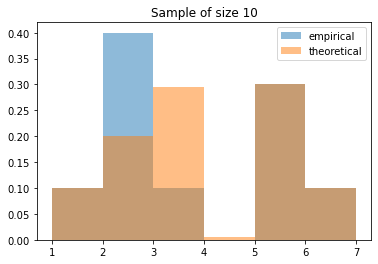

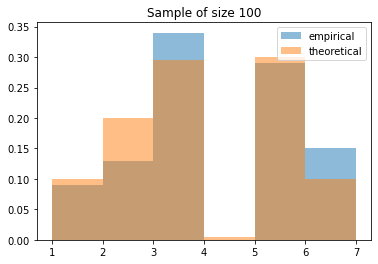

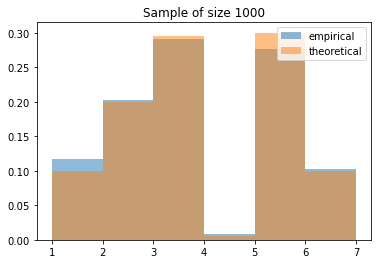

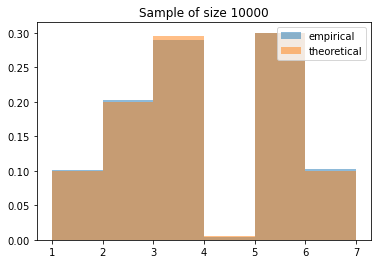

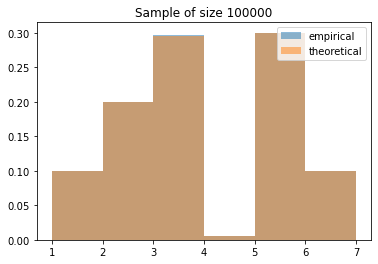

In [34]:
x = np.array([1,2,3,4,5,6])
p = np.array([1/10,2/10, 2.95/10,0.05/10, 3/10, 1/10])
bins = np.append(x,7)

for n in range(1, 6):
    N = 10**n
    empirical = generate_N_samples(x, p, N)
    
    plt.title("Sample of size " + str(N))
    plt.hist(empirical,alpha=0.5, bins = bins, label='empirical', density =True)
    plt.hist(x ,alpha=0.5,bins =bins , weights = p, label='theoretical' )
    plt.legend(loc='upper right')
    plt.show()

    

# <center> Exercise 2: GMM and EM

### Question 1. Likelhood function
The parameter of the model are $\theta = (\alpha_j, \mu_j, \Sigma_j)_{1 \leq j \leq m}$ ad the likelihood is given by:
$$
\mathcal{L}(x_1, ...., x_n; \theta) = \prod_{i=1}^n f_\theta(x_i) = \prod_{i=1}^n \left(\sum_{j=1}^{m}f_\theta(x_i|z_i = j)f_\theta(z_i = j)\right) = \prod_{i=1}^n \left( \sum_{j=1}^{m}\alpha_j \mathcal{N}(x_i;\mu_j, \Sigma_j)\right)
$$

where $\mathcal{N}(x_i;\mu_j, \Sigma_j)$ denotes the p.d.f. of the Gaussian distribution with median mean $\mu_j$ and variance matrix $\Sigma_j$ evaluated on $x_i$.

### Question 2. Sampling GMM
We consider $m = 3$, i.e. the random variable $Z$ takes values in ${1, 2, 3}$. Moreover, we consider:

$$
\mathbb{P}(Z=1)= \alpha_1 = 2/8;  
\mathbb{P}(Z=2)= \alpha_2 = 3/8; 
\mathbb{P}(Z=3)= \alpha_3 = 3/8; \\
$$
$$
\mu_1=(30,5); \mu_2=(5,30);\ mu_3=(15,15) \\
$$

<center> $ \Sigma_1^c$ = $
\begin{bmatrix} 1 & 0 \\
0 & 1 \end{bmatrix}$; $\Sigma_2^c$ = 
$\begin{bmatrix}3 & 1 \\
1 & 5
\end{bmatrix}$;$\Sigma_3^c $= $\begin{bmatrix}3 & 1 \\
0 & 2
\end{bmatrix}$
<br/><br/>

Where $\Sigma_i^c$ for $i=1,2,3$ denotes the matrix from the Choleski factorization of the actual covariance matrix, since, this way, we ensure $\Sigma_i = \Sigma_i^c{\Sigma_i^c}^T$ to be positive semidefinite. Moreover, it will be usefull to convert a standard sample to a sample with these covariance matrices.
    
    
For each sample $y$ of the GMM, we will first sample the latent variable $z$ using the algorithm implemented on exercise 1. Then, we will sample $y$ according to the distribution $y|z$, which will be a Gaussian distribution with paremeters depending on the value of $z$, using the Marsaglia Bray algorithm.

We take into account that a vector of two random variables with standard normal distribution follows a standard gaussian distribution in two dimension. Moreover, we will use the fact that if $Z$ is a vector of i.i.d. random variables following a satandard normal distribution, then: 
<br/><br/>
<center> $X:=\Sigma^c Z + \mu \sim \mathcal{N}(\mu, \Sigma)$ where $\Sigma=\Sigma^c{\Sigma^c}^T $
    
    
 i.e. $\Sigma_i^c$ is the matrix retreived from the Cholesky decomposition of $\Sigma$.

In [35]:
 def Marsaglia_Bray():
        '''
        Creates a sample of a gaussian distribution in 2 dimensions following the 
        Marsaglia Bray algprithm.
        
        :return : vector of R^2 sampled according to a gaussian distribution.
        '''
        v1=1
        v2=1
        while v1**2+v2**2>1:
            v1=2*np.random.rand()-1
            v2=2*np.random.rand()-1
        
        s=np.sqrt(-2*np.log(v1**2+v2**2))
        t = np.sqrt(v1**2+v2**2)
        
        return np.array([[s*v1/t, s*v2/t]])

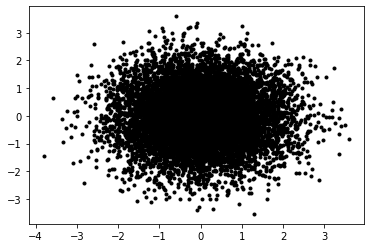

In [36]:
#Checking if algorithm gives normal distribution
normal = np.array(Marsaglia_Bray())
for i in range(10000):
    normal = np.concatenate((normal, Marsaglia_Bray()), axis=0 )

plt.plot(normal[:, 0], normal[:, 1], '.', color='black');

In [37]:
def sample_GMM(alpha, mu, choleski_sigma, size):
    '''
    Creates a sample of a Gaussian Mixture Model according to the given parameters.
    We assume the parameters are ordered and of the same size.
    
    :param alpha: parameters of the discrete distribution of the latent variable
    :param mu: medians of the normal distributions
    :param choleski_sigma: matrices from cholesky decomposition of  the variance matrices of the normal distributions
    '''
    x = np.array(list(range(alpha.size))) #values that can be taken by the latent variable Z
    
    for i in range(size):
        #sample z_i
        z = sim(x,alpha) 
        #sample y_i according to y_i|z_i
        aux = Marsaglia_Bray()
        y = np.dot(aux,choleski_sigma[z])+mu[z]
        if i==0: sample = y
        else: sample = np.concatenate((sample,y), axis = 0)
        
        
    return sample

Using the parameters chosen above, we obtain the following sample of the Gaussian Mixture model:

[[30.48212459  5.06407996]
 [ 3.90924227 33.03054498]
 [30.63296701  4.44502086]
 ...
 [27.75983431  5.70748146]
 [15.92147436 17.81011379]
 [ 6.44111272 31.80508088]]


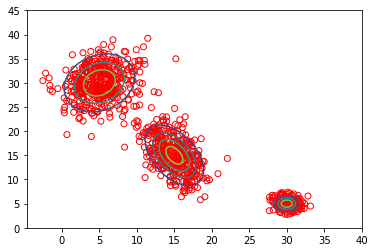

In [38]:
mu = np.array([[30,5],
              [5,30],
              [15,15]])


choleski_sigma = np.array([[[1,0],[0,1]],
                 [[2,3],[-2,2]],
                 [[2,-3],[1,2]]])

sigma = np.asarray([np.matmul(matrix.T,matrix) for matrix in choleski_sigma])

alpha = np.array([1/4, 3/8, 3/8])

sample = sample_GMM(alpha, mu, choleski_sigma, 1000)

print(sample)
#Plot sample and distributions.
plt.scatter(sample[:,0], sample[:,1],marker ='o', zorder = 0, facecolors='none', edgecolors='red', alpha=1)
N = 100
ranges=[[0,40,15],[15, 15,45],[0,20,30]]

for i in range(mu.shape[0]): 
    X    = np.linspace(0, ranges[i][1], N)
    Y    = np.linspace(ranges[i][0], ranges[i][2], N)
    X, Y = np.meshgrid(X, Y)
    pos  = np.dstack((X, Y))
    rv   = multivariate_normal(mu[i], np.matmul(choleski_sigma[i].T,choleski_sigma[i]))
    Z    = rv.pdf(pos)
    plt.contour(X, Y, Z,4, alpha=1, zorder = i+1)


plt.show()

### Question 3.  EM algorithm for GMM models


**E-Step** 

We consider the EM algorithm for this particular model. We first need to check if we can obtain an analytical formula for the posterior probability of the latent variable $Z$. For fixed values of $\theta = (\alpha_j,\mu_j,\Sigma_j)_{j=1,...,m}$ we have the following:

$$
f_\theta(z_i=j|x_i)= \frac{f_\theta(x_i|z_i=j)f_\theta(z_i=j)}{f_\theta(x_i)} = \frac{\mathcal{N}(x_i; \mu_j, \Sigma_j)\alpha_j}{\sum^{m}_{k=1}p(z_i=k)\mathcal{N}(x_i; \mu_k, \Sigma_k)} = \frac{\mathcal{N}(x_i; \mu_j, \Sigma_j)\alpha_j}{\sum^{m}_{k=1}\alpha_k\mathcal{N}(x_i; \mu_k, \Sigma_k)} =: \tau_{ij}(\theta)
$$

Then, the function that has to be computed in the E-step on the $t+1$ iteration of the EM algorithm is: 

$$
Q(\theta, \theta_t) = \mathbb{E}_{Z\sim f_{\theta_t} (Z|X)}[log(f_\theta(Z,X))] =
\sum^{n}_{i=1}\mathbb{E}_{Z_i\sim f_{\theta_t}(Z_i|X_i)}[log(f_\theta(Z_i,X_i))] = \sum^{n}_{i=1}\left\{\sum_{j=1}^{m} \tau_{ij}log(f_\theta(z_i=j)f_{\theta_t}(x_i|z_i=j)) \right\}
=
$$

$$ \sum^{n}_{i=1}\left\{\sum^{m}_{j=1}\tau_{ij}(\theta_t) \left(log(\alpha_j)+log\left(\mathcal{N}(x_i; \mu_j, \Sigma_j)\right)\right)\right\} $$

Where we used that $$log f_\theta(z_i=j,x_i) = log (f_\theta(x_i|z_i = j)f_\theta(z_i=j)) = log(\alpha_j)+log\left(\mathcal{N}(x_i; \mu_j, \Sigma_j)\right) ,  \forall i\in\{1,...,n\}, j\in\{1,...,m\}$$

Overall, the E-step consists on computing $t_{ij}$ for $i \in {1,...,n}$ and $j \in {1,...,m}$.

In [39]:

def expectation_EMM(x, alpha_t, mu_t, sigma_t ):
    '''
    E-step for the EM algorithm for a GMM model.
    
    :param x: sample
    :param alpha_t, mu_T, sigma_t: parameters to optimize in the EM algorithm
    '''

    evaluated_pdf = np.asarray([[multivariate_normal(mean=mu, cov=sigma).pdf(x_i) for x_i in x] 
                               for  (mu,sigma) in zip(mu_t, sigma_t)])
    
    
    denominators = np.dot(alpha_t.T, evaluated_pdf ) #tendrá tamaño 1xn
    
    tau = np.asarray([[(alpha_t[j][0]*evaluated_pdf[j][i])/denominators[0][i] for j in range(alpha_t.shape[0])] for i in range(x.shape[0])])

    return tau


**M-step**

In this step we must maximize the function $Q(\theta, \theta_t)$ derived in the previous step with respect to $\theta = (\alpha_j, \mu_j, \Sigma_j)_{j=1,...n}$.

**1.Parameters $\alpha$**

We will minimize using the  method of Lagrange multipliers, since we need to take into account that the minimization of $Q(\theta, \theta_t)$ with respect to $(\alpha_1,...,\alpha_m)$ is constrained to $\sum^{m}_{j=1}\alpha_j = 1$. Denoting $\alpha = (\alpha_1,... \alpha_m)$, we consider the Lagrangian function:
$$
\mathcal{L}(\alpha, \lambda) = Q(\theta, \theta_t) + \lambda(1-\sum^{m}_{j=1}\alpha_j)
$$

To simplify the notation we ignore for now the dependence of $\tau$ on $\theta$. Taking derivatives we get:

$$
\frac{\partial \mathcal{L}}{\partial \alpha_j} (\alpha, \lambda) = \sum^{n}_{i=1} (\frac{\tau_{ij}}{\alpha_j}) - \lambda \implies \hat{\alpha}_j = \frac{\sum^{n}_{i=1} \tau_{ij}}{\lambda} \forall j = 1, ..., m 
$$

$$
\frac{\partial \mathcal{L}}{\partial \lambda} (\hat{\alpha}, \lambda) = 1 - \sum^{m}_{j=1}\hat{\alpha}_j = 1 - \sum^{m}_{j=1}\frac{\sum^{n}_{i=1} \tau_{ij}}{\lambda}= 0 \implies \lambda = \sum^{n}_{i=1}1 = n \implies \lambda = n
$$

Where we used the fact that $\sum_{j=1}^{m}\tau_{ij} = \sum_{j=1}^{m}p(z_i = j|x_i) = 1$. We conclude then that the values of $\alpha$ that maximize $Q(\theta, \theta_t)$ are:

$$
\hat{\alpha}_j = \frac{\sum^{n}_{i=1} \tau_{ij}}{n},  j = 1, ..., m 
$$


**2.Parameters $\mu$**

Since, if $X_i\in\mathbb{R}^K$, then $log(\mathcal{N}(x;\mu,\Sigma))=-log(\sqrt{(2\pi)^K det(\Sigma)})-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu))$, then, we can obtain the maximizing values of $\mu = (\mu_1,...\mu_m)$

$$
\frac{\partial Q}{\partial \mu_j} (\theta, \theta_t) = \sum^{n}_{i=1}\tau_{ij}(\Sigma^{-1}_j(x_i-\mu_j)) = 
\Sigma^{-1}_j\left( \sum^{n}_{i=1}\tau_{ij}x_i - \mu_j\sum^{n}_{i=1}\tau_{ij} \right) \implies
$$

$$
\hat{\mu}_j = \frac{\sum^{n}_{i=1}\tau_{ij}x_i}{\sum^{n}_{i=1}\tau_{ij}}
$$


**3. Parameters $\Sigma$**
We proceed analogously for the covariance matrices:

$$\frac{\partial Q}{\partial \Sigma_j} (\theta, \theta_t) = \sum^{n}_{i=1}\left(\frac{1}{2}\Sigma_j\tau_{ij} - \frac{1}{2}(x_i-\mu_j)(x_i-\mu_j)^T\tau_{ij}\right) = 0 $$
$$ \implies \Sigma_j = \frac{\sum^{n}_{i=1}(x_i-\mu_j)(x_i-\mu_j)^T\tau_{ij}}{\sum^{n}_{i=1}\tau_{ij}}, \forall j= 1, ..., m$$ 


Therefore, the M-step for these models consists of implementing these formulas with the values of $\tau_{ij}$ given by the E-step.


In [40]:
def maximization_GMM(tau, x):
    '''
    M-step for the EM algorithm for a GMM model:
    
    :param x: sample
    :param tau: posterior probabilities for each cluster
    '''
    n = x.shape[0] #number of observations
    m = tau.shape[1] #cadinality of the space of the latent variables
        
    if(tau.shape[0]!=n or tau.shape[1]!=m):
        if tau.shape[0]==m or tau.shape[1]!=n : tau = tau.T
        else: 
            print("Error with dimensions")
            return
    tau_summed = tau.sum(axis =0) # si tau tiene tamaño n(filas)x m, entonces tau_sumed tiene m columnas y 1 fila
    
    
    alpha = np.asarray([[tau_summed[j]/n] for j in range(m)])

    
    mu = np.asarray([np.dot(tau[:,j],x)/tau_summed[j] for j in range(m)])

    numerator_array = np.asarray([[x[i]-mu[j] for j in range(m) ]for i in range(n)])
    
    
    #sigma = np.asarray([[(np.outer(numerator_array[i,:],numerator_array[i,:])*tau[i,:]).sum(axis=0)/tau_summed[0, j] 
                         #for i in range(n)]for j in range(m)])
    sigma = np.zeros((m, x.shape[1], x.shape[1]))
    
    for j in range(m):
        for i in range(n):
            sigma[j] += np.outer(x[i]-mu[j],x[i]-mu[j])*tau[i,j]/tau_summed[j]
    
    return alpha,mu,sigma
    

In [41]:
def log_likelihood(X, alpha, mu, sigma):
    '''
    log-likelihood of a sample with a GMM distribution.
    
    :para X: sample
    :para alpha: probability for each cluster
    :param mu: vector with the mean of each gaussian
    :param sigma: vector with the covariance matrices fot each gaussian
    '''
    n = X.shape[0]
    m = alpha.shape[0]
    likelihood=0  
    sum_i=0
    
    for i in range(n):
        for j in range(m):
            try: sum_i = sum_i + alpha[j]*multivariate_normal(mean=mu[j], cov=sigma[j]).pdf(X[i])
            except: 
                #Exceptions will be thrown if the covariance matrix is singular. We add small numbers to the
                # diagonal to handle it
                sigma[j]=sigma[j]+np.identity(sigma[j].shape[0])*0.0001 
                sum_i = sum_i + alpha[j]*multivariate_normal(mean=mu[j], cov=sigma[j]).pdf(X[i])
        likelihood = likelihood + np.log(sum_i)
        sum_i=0
            
    return likelihood  


In [42]:
def EM_GMM(x, alpha0, mu0, sigma0,miniter, eps, plot):
    alpha_t = alpha0
    mu_t = mu0
    sigma_t = sigma0
    new= 0
    iterations = 0
    likelihood = np.asarray([2*eps])
    
    while np.abs(likelihood[-1]-new)>eps or iterations<miniter:
        tau_t = expectation_EMM(x, alpha_t, mu_t, sigma_t )
        alpha_t, mu_t, sigma_t = maximization_GMM(tau_t, x)
        #print(alpha_t, mu_t, sigma_t)
        likelihood = np.append(likelihood, new)
        new = log_likelihood(x, alpha_t, mu_t, sigma_t)
        iterations+=1
    if(plot):
        plt.plot(list(range(1,iterations)),likelihood[2:]) 
        plt.ylabel('Log-likelihood')
        plt.xlabel('Iteration')
        plt.title('Log-Likelihood in each iteration')
        plt.show()
        
    return alpha_t, mu_t, sigma_t, new

We may now test it in the sample created in question 2. We set the minimum iterations to be 10, since, depending on initial values, it might have a considerable *heating time*. Moreover, we test it on some randomly chosen initial values.

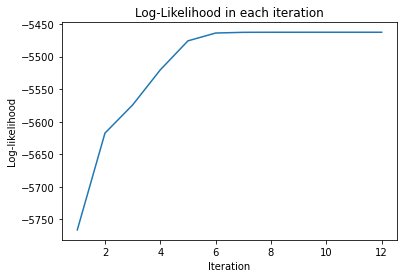

-------------
Real Values :
Vector of alpha:
[0.25  0.375 0.375]
Vector of mu (means):
[[30  5]
 [ 5 30]
 [15 15]]
Vector of sigma (covariances):
[[[ 1  0]
  [ 0  1]]

 [[ 8  2]
  [ 2 13]]

 [[ 5 -4]
  [-4 13]]]
Real value of the log-likelihood -5474.74459996196
-------------
Predicted Values :
Vector of predicted alpha:
[[0.225     ]
 [0.39834461]
 [0.37665539]]
Vector of predicted mu (means):
[[29.98989831  5.06955591]
 [ 5.10161081 30.00762433]
 [14.88501078 15.20511569]]
Vector of predicted sigma (covariances):
[[[ 1.01433125 -0.11286733]
  [-0.11286733  0.84660323]]

 [[ 6.71570894  1.93475884]
  [ 1.93475884 11.26541207]]

 [[ 4.77859646 -4.10201752]
  [-4.10201752 13.58446046]]]
Estimated value of the log-likelihood:  -5462.647574236887


In [43]:
mu0 = np.array([[20,1],
              [5,20],
              [10,8]])

sigma0 = np.array([[[1,0],[0,1]],
                 [[1,0],[0,1]],
                 [[1,0],[0,1]]])

alpha0 = np.array([[1/3], [1/3], [1/3]])

alpha_EM, mu_EM, sigma_EM , predicted_likelihood= EM_GMM(sample, alpha0, mu0, sigma0,10, 0.00001, True)

print('-------------')

print('Real Values :')
print('Vector of alpha:')
print(alpha)
print('Vector of mu (means):')
print(mu)
print('Vector of sigma (covariances):')
print(sigma)
print('Real value of the log-likelihood',log_likelihood(sample, alpha,mu, sigma ) )

print('-------------')

print('Predicted Values :')
print('Vector of predicted alpha:')
print(alpha_EM)
print('Vector of predicted mu (means):')
print(mu_EM)
print('Vector of predicted sigma (covariances):')
print(sigma_EM)
print('Estimated value of the log-likelihood: ',predicted_likelihood[0] )



### Question 4
We observe that the results depend a lot on the initial values. If our initial values are well selected, it will converge well. I especially observed the effect of the initial means, since I chose the covariance matrices to be the standard ones. If all points are yo far from one of the clusters, the model will oversee it and end up with a cluster with very low probability badly aproximated.






### Question 5


We observe that the data does not present clear or *intuitive* clusters in the form of gaussian distributions. Hence, at first glace, a GMM does not seem as the optimal idea for this data.

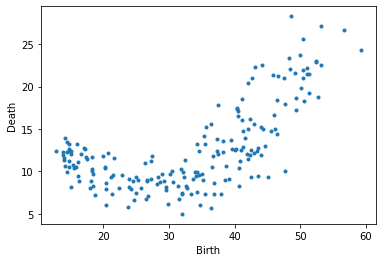

In [44]:
data = pd.read_csv('Crude-BirthDeath-Rate.csv')
birthrange = [np.min(data['Birth']), np.max(data['Birth'])]
deathrange = [np.min(data['Death']), np.max(data['Death'])]
plt.plot(data['Birth'], data['Death'], '.')
plt.xlabel('Birth')
plt.ylabel('Death')
plt.show()
data = data.to_numpy()

### Question 6.
For each value of $m$, i.e. the number of possible values of the latent variable, we will initialize the algorithm with $\alpha_i = 1/m$, $\Sigma_i = Id_{m\times m}$ and $\mu_i$ randomly (uniformly) selected over the range of the data. 

As seen in question 4, the results vary a lot depending on the initial values. What we will do now, is to initialize our algorithm using the k-means algorithm. We observe that this will give us the matrix $(\tau_{ij})_{i\in{1,...n}, j\in{1,...,m}}$. Hence, we will nees to do first an extra E-step ate the beginning.

In [61]:
        

def init_tau(X, k): 
    '''
    Function to initialize the tau parameter of the EM algorithm via k-means.
    
    :param X: data
    :param m: number of gaussians
    
    
    '''
    
    centers,labels = K_means(X,k)
    tau = np.zeros([X.shape[0],k])
    for i in range(X.shape[0]):
        tau[i][labels[i]]=1
   
    return tau

In [65]:
def K_means(data,k):
        
    centers = np.asarray([random.choice(data) for i in range(k)])
    
    return K_means_recursive(data, k, centers, np.zeros(data.shape[0]) )
    
def K_means_recursive(data, k, centers, old_labels):
    print('used')
    n = data.shape[0] #number of individuals in the data
        
    labels = np.zeros(n).astype(int) #label of each individual
    
    clusters = [np.empty([1,data.shape[1]]) for j in range(k) ] #list with the arrays of elements in each cluster
    
    #We cluster each observation in the cluster with the closest center   
    for i in range(n):
        for j in range(k):
            if j == 0: 
                dist = np.linalg.norm(data[i] - centers[j])
            else:
                if np.linalg.norm(data[i] - centers[j]) < dist:
                    labels[i] = j
                    dist = np.linalg.norm(data[i] - centers[j])
        
        clusters[labels[i]] = np.append(clusters[labels[i]],np.asarray([data[i]]), axis=0)
        
                
    #We recalculate de centers
    for i in range(k):
        clusters[i] = np.delete(clusters[i], 0, 0)
        centers[i] = (1/len(clusters[i]))*np.asarray(clusters[i]).sum(axis=0)
        #CONTROL WHEN A CLUSTER IS EMPTY AND HAVE TO DIVIDE BY 0
    
    if (old_labels!=labels).all():
        return K_means_recursive(data, k, centers, labels )
    else: 
        return centers, labels    
            

We also create a function that computes the BIC for each value of m.

In [66]:
def BIC_func(m, loglike, d, n):
    '''
    :param m: number of clusters
    :param loglike: value of the loglikelihood
    :param d: dimension of the data vectors
    :param n: number of samples
    
    '''
    degFree = m*d+m*d*(d+1)/2+(m-1) #possible values of mu, of sigma and alpha 
    return -loglike + (degFree*np.log(n))/2
    

used


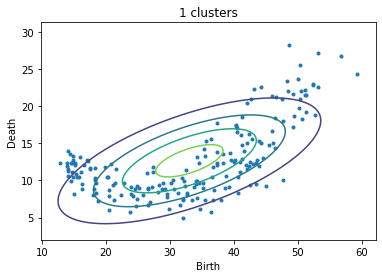

used


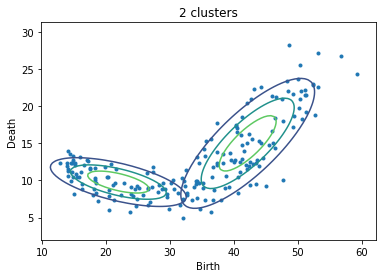

used


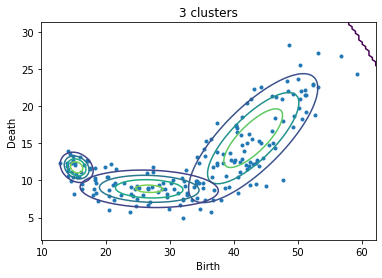

used


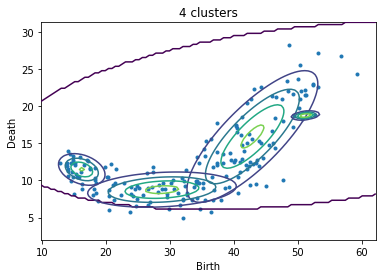

used


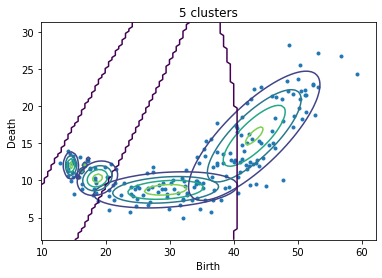

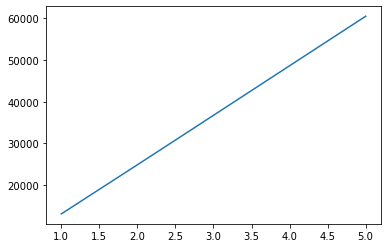

In [67]:
BIC = np.asarray([])

for m in range(1, 6):
    
    tau0 = init_tau(data, m)
    
    plt.plot(data[:,0], data[:,1], '.', zorder = 0, alpha=1)
    
    
    alpha0, mu0, sigma0 = maximization_GMM(tau0, data)
    
    alpha_EM, mu_EM, sigma_EM, new = EM_GMM(data, alpha0, mu0, sigma0,10, 0.001, False)
    
    BIC = np.append(BIC,BIC_func(m, new, X.shape[1], X.shape[0]))
    N = 100
    for i in range(mu_EM.shape[0]): 
        X    = np.linspace(birthrange[0]-3,birthrange[1]+3 , N)
        Y    = np.linspace(deathrange[0]-3,deathrange[1]+3, N)
        X, Y = np.meshgrid(X, Y)
        pos  = np.dstack((X, Y))
        rv   = multivariate_normal(mu_EM[i], sigma_EM[i])
        Z    = rv.pdf(pos)
        plt.contour(X, Y, Z,4, alpha=1, zorder = i+1)
        
    plt.xlabel('Birth')
    plt.ylabel('Death')
    plt.title(str(m) + ' clusters')
    plt.show()
    
    
plt.plot(list(range(1,6)), BIC)
plt.show()
    


In [ ]:
print(BIC)

We observe that according to the BIC criteria we get the best results when $m=$

# Exercise 3. Importance Sampling.

### 3.A. Poor Importance Sampling

####  Question 1.

In [ ]:
def p_3a(x):
    if x>=0: 
        return x**(0.65)*np.exp(-x**2/2)
    else: raise Exception("p can only be evaluated on nonnegative values")
        

In [ ]:
def f_3a(x):
    if x>=0: 
        return 2*np.sin((np.pi/1.5)*x)
    else: raise Exception("f can only be evaluated on nonnegative values")
        

In [ ]:
def q_3a(x, mean):
    return (2/np.sqrt(2*np.pi*1.5))*np.exp(-(mean-x)**2/3)

In [ ]:
def importance_sampling_ex3(N, mean):
    '''
    Importance sampling using normalized weights where g has mean mean and standard deviatoion 1.5
    
    '''
    size = 0
    sample = np.asarray([])
    
    #We first sample according to the distribution of q
    while ( size<N):
        two_samples = Marsaglia_Bray()*1.5 + mean
        if(two_samples[0][0]>=0):
            sample = np.append(sample, two_samples[0][0])
            size+=1
        if(two_samples[0][1]>=0 and size<N):
            sample = np.append(sample, two_samples[0][1])
            size+=1
            
    #We compute the weights
    w = np.asarray([p_3a(x)/q_3a(x, mean) for x in sample])
    
    normalized_w = w/np.mean(w)
    
    f = np.asarray([f_3a(x) for x in sample])
    
    expectancy = (1/N)*np.dot(normalized_w,f)
    
    return expectancy, normalized_w
    

In [ ]:
importance_sampling_ex3(2, 0.8)

####  Question 2.

In [ ]:
N_values = [10, 100, 1000, 10000]
means = np.asarray([])
variances = np.asarray([])

for N in N_values:
    estimations = np.asarray([])
    for i in range(100): estimations = np.append(estimations, importance_sampling_ex3(N, 0.8)[0])
    print('N : ', N)
    means = np.append(means,np.mean(estimations))
    print('Mean = ', means[-1])
    variances = np.append(variances, np.var(estimations))
    print('Variance = ', variances[-1])

    
plt.plot(N_values, means) 
plt.xlabel('Sample size')
plt.ylabel('Mean')
plt.show()

plt.plot(N_values, variances) 
plt.xlabel('Sample size')
plt.ylabel('Variance')
plt.show()


#### Question 3

We can see that for a shifted mean the variance is much bigger.

In [ ]:
weights1 = importance_sampling_ex3(100, 0.8)[1]
print('Mean and standard deviation of weights for mean 0.8')
print('Mean: ', np.mean(weights1), 'Variance: ', np.var(weights1))

weights2 = importance_sampling_ex3(100, 6)[1]
print('Mean and standard deviation of weights for mean 6')
print('Mean: ', np.mean(weights2), 'Variance: ', np.var(weights2))


### 3.B. Adaptative Importance Sampling

#### Question 4

We observe that the function that we want tp maximize in step (iii) is very similar of the log-likelihood of the GMM we maximized in exercise 2, except for the weights that are multiplying each term of the sum over $n$. We can then assume that for each $i$. Indeed, in exercise 2 we wanted to maximize:

$$log \mathcal{L}(x_1, ...., x_n; \theta) = \sum_{i=1}^n log(f_\theta(x_i)) = \sum_{i=1}^n log\left(\sum_{j=1}^{m}\mathcal{N}(x_i;\mu_j, \Sigma_j)\alpha_j\right) $$

We now want to maximize a sort of weighted log-likelihood:

$$   \sum_{i=1}^n \tilde{\omega}_i^{(0)}log\left(\sum_{j=1}^{m}\mathcal{N}(x_i;\mu_j, \Sigma_j)\alpha_j\right)$$


If we follow the same derivation for the EM algorithm to maximize the log likelihood as the one seen in class, we would find that the $Q(\theta, \theta_t)$ function for this weighted version is:

$$
Q(\theta, \theta_t) = \mathbb{E}_{Z\sim f_{\theta_t} (Z|X)}[\omega log(f_\theta(Z,X))] =\sum^{n}_{i=1}\sum_{j=1}^{m} \tau_{ij} \omega_i log(\alpha_j \mathcal{N}(x_i; \mu_j,\Sigma_j)) = \sum^{n}_{i=1}\sum_{j=1}^{m} \left(\tau_{ij} \omega_i log(\alpha_j) + \tau_{ij}log(\mathcal{N}(x_i; \mu_j,\frac{1}{\omega_i}\Sigma_j))\right)
$$

Where we used the fact that $\mathcal{N}(x;\mu, \Sigma)^\omega = \mathcal{N}(x;\mu,\frac{1}{\omega} \Sigma)$.


Now, for the M step, we want to maximize this function with respecto to $\theta = (\alpha_j, \mu_j, \Sigma_j)_{j = 1,...m}$. Proceeding as in exercise 2, we obtain:


$$
\hat{\alpha}_j = \frac{\sum^{n}_{i=1} \omega_i\tau_{ij}}{n},  j = 1, ..., m 
$$


$$
\hat{\Sigma}_j = \frac{\sum_{i=1}^{n}(x_i-\mu_j)\tilde{\omega}_i(x_i-\mu_j)^T\tau_{ij}}{\sum^{n}_{i=1}\tau_{ij}}
$$

$$
\hat{\mu}_j = \frac{\sum^{n}_{i=1}\tilde{\omega}_i\tau_{ij}x_i}{\sum^{n}_{i=1}\tilde{\omega}_i\tau_{ij}}
$$

#### Question 5.

In [49]:
def M_AIM(tau, x, omega):
    '''
    M-step of the EM algorithm used in the third step of the Adaptative Importance Sampling.
    
    '''
    n = x.shape[0] #number of observations
    m = tau.shape[1] #cadinality of the space of the latent variables
        
    if(tau.shape[0]!=n or tau.shape[1]!=m):
        if tau.shape[0]==m or tau.shape[1]!=n : tau = tau.T
        else: 
            print("Error with dimensions")
            return
    tau_summed = tau.sum(axis =0) # si tau tiene tamaño n(filas)x m, entonces tau_sumed tiene m columnas y 1 fila
    
    mod_tau = np.asarray([omega[i]*tau[i,:] for i in range(n)]) #modified tau to compute mu and alpha
    mod_tau_summed = mod_tau.sum(axis=0) 
    
    alpha = np.asarray([[mod_tau_summed[j]/n] for j in range(m)])
    
    mu = np.asarray([np.dot(mod_tau[:,j],x)/mod_tau_summed[j] for j in range(m)])    
    
    sigma = np.zeros((m, x.shape[1], x.shape[1]))
    
    for j in range(m):
        for i in range(n):
            sigma[j] += np.outer(x[i]-mu[j],x[i]-mu[j])*tau[i,j]*omega[i]/mod_tau_summed[j]
    
        
    print('alpha', alpha)

    
    
    return alpha,mu,sigma

In [50]:
def sample_GMM_dim(alpha, mu, choleski_sigma, dim, size):
    '''
    Creates a sample of a Gaussian Mixture Model according to the given parameters.
    We assume the parameters are ordered and of the same size.
    
    :param alpha: parameters of the discrete distribution of the latent variable
    :param mu: medians of the normal distributions
    :param dim: dimension of the sample
    :param choleski_sigma: matrices from cholesky decomposition of  the variance matrices of the normal distributions
    '''
    x = np.array(list(range(alpha.size))) #values that can be taken by the latent variable Z
    
    if dim%2==0:
        for i in range(size):
            #sample z_i
            z = sim(x,alpha) 
            aux = np.asarray([])
            for j in range(int(dim/2)):
                #sample y_i according to y_i|z_i
                aux = np.append(aux,Marsaglia_Bray())
                
            y = np.dot(aux,choleski_sigma[z])+mu[z]
            if i==0: sample = [y]
            else: sample = np.concatenate((sample,[y]), axis = 0)
                
    else: 
        for i in range(size):
            #sample z_i
            z = sim(x,alpha) 
            aux = np.asarray([])
            j = 0
            while j<dim:
                if j+2<dim+1:
                    aux = np.append(aux,Marsaglia_Bray())
                    j+=2
                else:
                    aux = np.append(aux,Marsaglia_Bray()[0][0])
                    j+=1 
            y = np.dot(aux,choleski_sigma[z])+mu[z]
            if i==0: sample = [y]
            else: sample = np.concatenate((sample,[y]), axis = 0)
        
        
    return np.asarray(sample)

In [52]:
def objective(x, alpha, mu, sigma, omega):
    '''
    Objective function when using the EM algorithm for adaptative importance
    sampling.
    
    :param x:
    :param alpha,mu,sigma: parameters of the GMM
    :param omega: weights 
    '''
    n = x.shape[0]
    m = alpha.shape[0]
    value=0  
    sum_i=0
    for i in range(n):
        for j in range(m):
            try: sum_i = sum_i + alpha[j][0]*multivariate_normal(mean=mu[j], cov=sigma[j]).pdf(x[i])
            except: 
                #Exceptions will be thrown if the covariance matrix is singular. We add small numbers to the
                # diagonal to handle it
                sigma[j]=sigma[j]+np.identity(sigma[j].shape[0])*0.0001 
                sum_i = sum_i + alpha[j][0]*multivariate_normal(mean=mu[j], cov=sigma[j]+np.identity(sigma[j].shape[0])*0.0001 ).pdf(x[i])
        
        value = value + omega[i]*np.log(sum_i)
        sum_i=0
            
    return value  


In [53]:
x=np.array([[1,0],
            [0,0,],
           [1,0],
           [1,0]])
mu0 = np.array([[20,1],
              [5,20],
              [10,8]])

sigma0 = np.array([[[1,0],[0,1]],
                 [[1,0],[0,1]],
                 [[1,0],[0,1]]])

alpha0 = np.array([[1/3], [1/3], [1/3]])

In [54]:
def GMM_density(x, alpha, mu, sigma):
    '''
    Density function of a GMM.
    '''
    dens = 0
    m = alpha.shape[0]
    
    for i in range(m):
        dens = dens + alpha[i][0]*multivariate_normal(x,mu[i], sigma[i]).pdf(x)
        
    return dens
    

In [55]:
def weights_banana(x, alpha, mu, sigma):
    '''
    Weights to approximate a banana distribution with a GMM.
    
    '''
    dev_sqr = 1
    b = 0.4
    
    x_modified = np.asarray([y+np.asarray([0,b*(y[0]**2-dev_sqr),0,0,0]) for y in x])
    
    covariance = np.identity(5)
    covariance[0][0] = dev_sqr**2
     
            
    w=np.asarray([])
    
    for y,z in zip(x, x_modified):
        a = np.log(GMM_density(y, alpha, mu, sigma))
        b = np.log(multivariate_normal.pdf(z, np.zeros(5), covariance))
        w = np.append(w, b-a)
           
    normalized_w = np.exp(w)/np.sum(np.exp(w))
    
    print(normalized_w)
        
    return normalized_w

In [56]:
def PMC(alpha0, mu0, sigma0, dim, eps, outeriter):
    '''
    Population Monte Carlo Algorithm in a recursive form.
    
    :param alpha0, mu0, sigma0: initial values
    :param dim: dimension of the data X
    :param eps: tolerance
    :outeriter: outer iterations completed so far.
    '''
    alpha_t = alpha0
    mu_t= mu0
    sigma_t= sigma0
    new = -1*np.inf
    prev = 1
    outeriter+=1
    inneriter=0
    print('PMC iteration', outeriter)
    
    #Generate random samples from the distribution
    choleski_sigma0 = np.asarray([np.linalg.cholesky(sigma) for sigma in sigma0])
    sample = sample_GMM_dim(alpha0,mu0,choleski_sigma0, dim, 2)
    
    #Compute weights
    omega = weights_banana(sample,alpha_t, mu_t, sigma_t)
    while np.abs(prev-new)>eps and inneriter<15:
        #EM of to find next density
        tau_t = expectation_EMM(sample, alpha_t, mu_t, sigma_t )
        alpha_t, mu_t, sigma_t = M_AIM(tau_t, sample, omega)
        
        prev = new
        new = objective(sample, alpha_t, mu_t, sigma_t, omega)
        inneriter=+1
    
    if abs(objective(sample,alpha0, mu0, sigma0, omega) - new)>eps and outeriter <30:
        return PMC( alpha_t, mu_t, sigma_t, dim, eps, outeriter)
    else: 
        return alpha_t, mu_t, sigma_t

In [57]:
def init_banana(dim, m):
    '''
    Initilalization for the banana 
    '''
    alpha = np.asarray([[al] for al in np.ones(m)/m ])
    mu=np.asarray([np.random.uniform(size=dim) for x in range(m)])
    sigma=np.asarray(m*[np.eye(dim)])
    
    return alpha,mu,sigma
    

In [58]:
def AIS_banana():
    '''
    Adaptative Importance Sampling to sample a Banana shape distribution 
    using the Population Monte Carlo to find optimal solutions.
    '''
    #inicializar alpha0, mu0, sigma0,dim
    dim = 5
    
    alpha0,mu0,sigma0 = init_banana(5, 2)

    alpha, mu, sigma = PMC(alpha0, mu0, sigma0, 5, 0.1,0)
    
    choleski_sigma = np.asarray([np.linalg.cholesky(sig) for sig in sigma])
    
    banana_sample = sample_GMM_dim(alpha, mu, choleski_sigma, 5, 10000)
    banana_sample =  np.asarray(sim_MixtureGaus(10000,alpha,mu,sigma)['sim'])
    return banana_sample
    

In [59]:
banana= AIS_banana()

PMC iteration 1
[0.4801384 0.5198616]
alpha [[0.17623979]
 [0.32376021]]
alpha [[0.17625474]
 [0.32374526]]
PMC iteration 2


ValueError: the input matrix must be positive semidefinite

In [60]:

plt.plot(banana[:,0], banana[:,1], '.')
plt.show()


NameError: name 'banana' is not defined

For some reason I could not find the algorithm does not work. It either gives a distribution that does not look like the banana sjape density, or the values in alpha or the weights go to infinity.